In [8]:
# 必要なライブラリのインクルード
import os
import re
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,  Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np# 元となる画像の読み込み
%matplotlib inline

# 関数定義

In [228]:
# opencv画像入力用
from IPython.display import display, Image

def display_cv_image(image, format='.JPG'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(Image(data=decoded_bytes))

def readyForGuess(img_name,width):
    img = cv2.imread( "./img/"+img_name+".jpg", cv2.IMREAD_GRAYSCALE)
    size = (3*width,4*width)
    #Create Small Size Image
    length=size[0]*size[1]
    img = cv2.resize(img, size)
    img_dat = img/255
    img_dat = img_dat.reshape(1,length)
    return img_dat

def showDiff(num):
    print("raw")
    display_cv_image(raw_img[num])
    print("processed")
    display_cv_image(proc_img[num])
    print("diff")
    display_cv_image(diff_img[num])
    

# 画像読み込み

In [244]:
#画像読み込みします
width = 120
size = (3*width,4*width)
length=size[0]*size[1]

raw_img = []
proc_img = []
# diff_img = []
eye_img = []

dir = os.getcwd()# カレントディレクトリのパスを取得


#positive
pos_dir = dir+"/img/raw/"
files = os.listdir(pos_dir)# ファイルのリストを取得
for file in files:# ファイルの数だけループ
    index = re.search('.JPG', file)# 拡張子がjpgのものを検出
    if index:# jpgの時だけ
        read_img = cv2.imread( pos_dir+file, cv2.IMREAD_GRAYSCALE)
        read_img = cv2.resize(read_img, size)
        read_img = read_img
        raw_img.append(read_img)
#negative
neg_dir = dir+"/img/processed/"
files = os.listdir(neg_dir)# ファイルのリストを取得
for file in files:# ファイルの数だけループ
    index = re.search('.JPG', file)# 拡張子がjpgのものを検出
    if index:# jpgの時だけ
        read_img = cv2.imread( neg_dir+file,cv2.IMREAD_GRAYSCALE)
        read_img = cv2.resize(read_img, size)
        read_img = read_img
        proc_img.append(read_img)

#eye
neg_dir = dir+"/img/eye/"
files = os.listdir(neg_dir)# ファイルのリストを取得
for file in files:# ファイルの数だけループ
    index = re.search('.JPG', file)# 拡張子がjpgのものを検出
    if index:# jpgの時だけ
        read_img = cv2.imread( neg_dir+file,cv2.IMREAD_GRAYSCALE)
        read_img = cv2.resize(read_img, size)
        read_img = read_img
        eye_img.append(read_img)



# arrayに変換
raw_img = np.asarray(raw_img)
proc_img = np.asarray(proc_img)
eye_img =np.asarray(eye_img)

# diff_img = raw_img*0 #真っ黒のボックスを作成

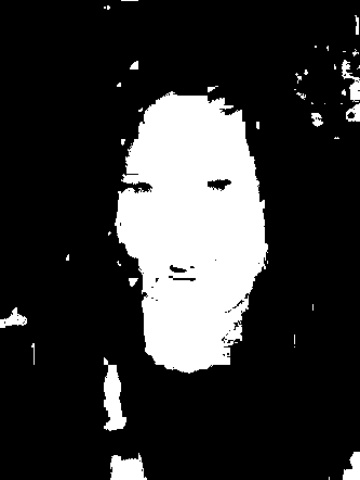

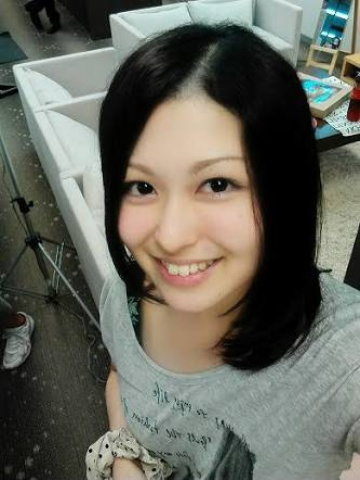

In [369]:
def find_rect_of_target_color(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV_FULL)
    h = hsv[:, :, 0]
    s = hsv[:, :, 1]
    return h,s

im = cv2.imread("./img/raw/1.JPG")
h,s = find_rect_of_target_color(im)

#肌色のマスクを作成
mask = np.zeros(h.shape, dtype=np.uint8)
mask[((0 < h) & (h < 30)) & ( 10 < s) & ( s <255)] = 255

mask = cv2.resize(mask, size)
im = cv2.resize(im, size)
display_cv_image(mask)
display_cv_image(im)





# Haarlike 特徴検出

(99, 41)
(26, 44)


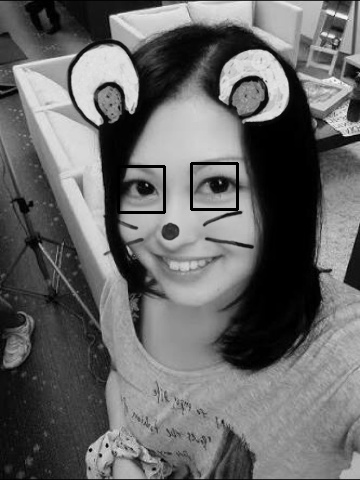

(104, 46)
(34, 52)


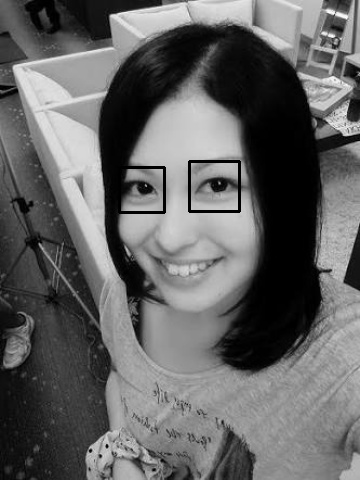

In [237]:

# display_cv_image(proc_img[0])
face_cascade = cv2.CascadeClassifier('/usr/local/Cellar/opencv/3.3.0_3/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('/usr/local/Cellar/opencv/3.3.0_3/share/OpenCV/haarcascades/haarcascade_eye.xml')
# 顔を検知

img = proc_img[0]
faces = face_cascade.detectMultiScale(img)

for (x,y,w,h) in faces:
    counter = 0
    # 検知した顔を矩形で囲む
#     cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    # 顔画像（グレースケール）
    roi_gray = img[y:y+h, x:x+w]
    # 顔ｇ増（カラースケール）
    roi_color = img[y:y+h, x:x+w]
    # 顔の中から目を検知
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        # 検知した目を矩形で囲む
        counter +=1
        if(counter>=3):
            break
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        print((ex,ey))
        
display_cv_image(img)

img = raw_img[0]
faces = face_cascade.detectMultiScale(img)

for (x,y,w,h) in faces:
    counter = 0
    # 検知した顔を矩形で囲む
#     cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    # 顔画像（グレースケール）
    roi_gray = img[y:y+h, x:x+w]
    # 顔ｇ増（カラースケール）
    roi_color = img[y:y+h, x:x+w]
    # 顔の中から目を検知
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        # 検知した目を矩形で囲む
        counter +=1
        if(counter>=3):
            break
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        print((ex,ey))
        
display_cv_image(img)

# SIFT特徴検出

In [249]:
import cv2

# 画像ファイルの読み込み
img = proc_img[0]

# # ORB (Oriented FAST and Rotated BRIEF)
# detector = cv2.ORB_create()

# # 特徴検出
# keypoints = detector.detect(img)

# # 画像への特徴点の書き込み
# out = cv2.drawKeypoints(img, keypoints, None)

# # 表示
# display_cv_image(out)
# cv2.imshow("keypoints", out)


# def sift(path):
#     import cv2
#     import numpy as np
#     import matplotlib.pyplot as plt
    
#     img = cv2.imread(path)
#     grayed = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    

    
#     img = cv2.drawKeypoints(grayed, points, None)
#     plt.imshow(img)

# sift(IMAGE_PATH)




AttributeError: module 'cv2.cv2' has no attribute 'xfeatures2d'

# パターンマッチング

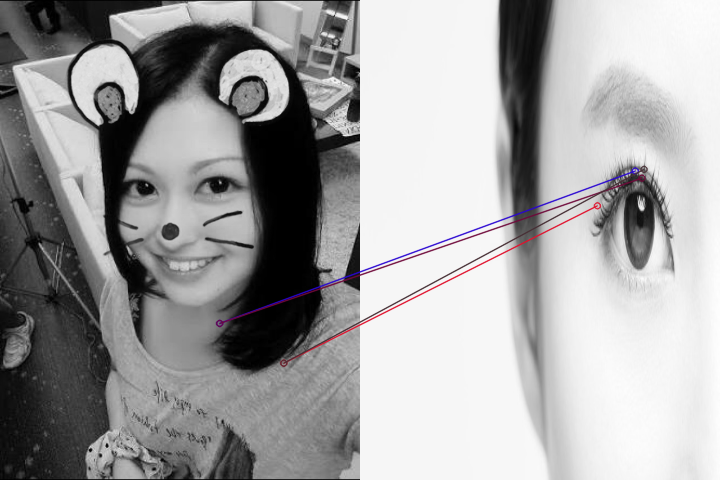

In [245]:
# 画像読込
img1 = proc_img[0]
img2 = raw_img[0]
img2 = eye_img[0]


# A-KAZE検出器の生成
detector = cv2.AKAZE_create()

# 特徴量の検出と特徴量ベクトルの計算
kp1, des1 = detector.detectAndCompute(img1, None)
kp2, des2 = detector.detectAndCompute(img2, None)

# Brute-Force Matcherの生成
bf = cv2.BFMatcher()

# 特徴量ベクトル同士をBrute-Force＆KNNでマッチング
matches = bf.knnMatch(des1, des2, k=2)

# データを間引く
ratio = 0.2
good = []
for m, n in matches:
    if m.distance < ratio * n.distance:
        good.append([m])

# 特徴量をマッチング状況に応じてソート
good = sorted(matches, key = lambda x : x[1].distance)

# 対応する特徴点同士を描画
img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good[:2], None, flags=2)

display_cv_image(img3, '.png')

In [193]:
# img_03_07 = cv2.addWeighted(raw_img[0], 20, proc_img[0], 20, 2.2)
# cv2.imwrite('img_0.5_0.5.jpg', img_03_07)
raw_img.astype(int) 
proc_img.astype(int)
diff_img = raw_img - proc_img
diff_img = abs(diff_img)
diff_img = np.uint8(diff_img)

raw


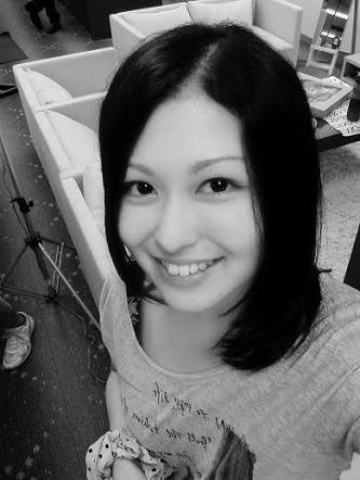

processed


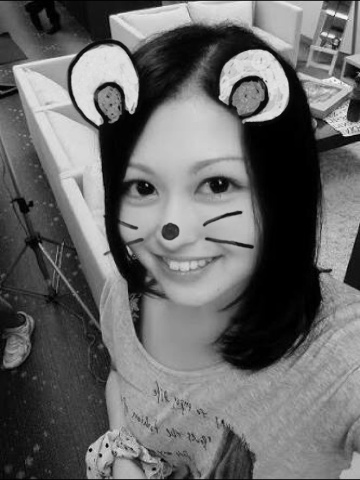

diff


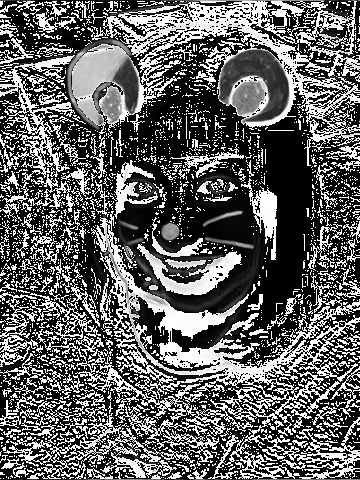

In [165]:
num = 0
showDiff(num)